In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


class Resident(Agent):
    
    def __init__(self, unique_id, model, income, hukou_status):
        super().__init__(unique_id, model)
        self.income = income
        self.hukou_status = hukou_status
        self.satisfaction = self.random.uniform(0.4, 0.6)
        self.property = None
        self.previous_income = income

    def step(self):
        self.update_satisfaction()
        self.update_income()
        if self.satisfaction < 0.5:
            self.consider_moving()

    def update_income(self):
        base_change = self.random.normalvariate(0.005, 0.01)  
        if self.income > np.median([r.income for r in self.model.schedule.agents if isinstance(r, Resident)]):
            change = base_change * 1.2  
        else:
            change = base_change * 0.8  
        self.income *= (1 + change)
        self.income = max(self.income, self.previous_income * 0.95)

    def update_satisfaction(self):
        base_satisfaction = 0.5  
        if self.property:
            neighborhood = self.model.grid.get_neighbors(
                self.pos, moore=True, include_center=False)
            property_neighbors = [
                agent for agent in neighborhood if isinstance(agent, Property)]
            if property_neighbors:
                avg_neighbor_value = np.mean(
                    [agent.value for agent in property_neighbors])
                max_value = max(self.property.value, avg_neighbor_value)
                if max_value > 0:
                    property_satisfaction = 0.2 * (1 - abs(self.property.value - avg_neighbor_value) / max_value)
                else:
                    property_satisfaction = 0.1
            else:
                property_satisfaction = 0.1
        else:
            property_satisfaction = -0.1

        income_change = (self.income - self.previous_income) / self.previous_income if self.previous_income > 0 else 0
        income_satisfaction = 0.2 * income_change

        hukou_satisfaction = 0 if self.hukou_status == "Local" else -0.05

        self.satisfaction = base_satisfaction + property_satisfaction + income_satisfaction + hukou_satisfaction
        self.satisfaction = max(0, min(1, self.satisfaction + self.random.uniform(-0.05, 0.05)))

        self.previous_income = self.income

        # Make it harder to reach very high satisfaction levels
        if self.satisfaction > 0.8:
            self.satisfaction = 0.8 + (self.satisfaction - 0.8) * 0.5

    def consider_moving(self):
        affordable_properties = [prop for prop in self.model.properties
                                 if prop.value <= self.income * 30 and (prop.owner is None or prop.owner == "Vacant")
                                 and (self.hukou_status == "Local" or not prop.hukou_restricted)]
        if affordable_properties:
            new_property = self.random.choice(affordable_properties)
            if self.property:
                self.property.owner = None
            self.model.grid.remove_agent(self)  # Remove current agent before moving
            self.property = new_property
            new_property.owner = self
            self.model.grid.place_agent(self, new_property.pos)


class Investor(Agent):
    def __init__(self, unique_id, model, capital):
        super().__init__(unique_id, model)
        self.capital = capital
        self.properties = []
        self.risk_tolerance = self.random.uniform(0.5, 1.5)  # Added: Risk tolerance

    def step(self):
        self.consider_buying()
        self.consider_selling()
        self.capital *= 1 + self.random.uniform(-0.01, 0.003)  # Added: Investment return
        self.capital = max(0, self.capital)  # Ensure capital is not negative

    def consider_buying(self):
        affordable_properties = [prop for prop in self.model.properties 
                                if prop.value <= self.capital * 0.5 and
                                (prop.owner is None or prop.owner == "Vacant")]
        if affordable_properties:
            # Determine investor type
            median_capital = np.median([i.capital for i in self.model.schedule.agents if isinstance(i, Investor)])
            is_high_end_investor = self.capital > median_capital

            if is_high_end_investor:
                properties_to_buy = sorted(affordable_properties, key=lambda x: x.value, reverse=True)[:3]
            else:
                num_to_buy = min(len(affordable_properties), self.random.randint(1, 3))
                properties_to_buy = self.random.sample(affordable_properties, num_to_buy)

            for prop in properties_to_buy:
                if self.capital >= prop.value and prop.expected_return() > 0.02:
                    self.buy_property(prop)

        # Create job opportunities
        if self.random.random() < 0.1:  # 10% chance to create jobs
            for _ in range(int(len(self.properties) / 2)):
                resident = self.random.choice([a for a in self.model.schedule.agents if isinstance(a, Resident)])
                resident.income *= 1.05  # Increase income

    def buy_property(self, property):
        if self.capital >= property.value:
            self.capital -= property.value
            self.properties.append(property)
            property.owner = self
            property.is_vacant = False  # Set to non-vacant after purchase

    def consider_selling(self):
        for property in self.properties:
            if property.expected_return() < 0.005 or (len(self.properties) > 5 and self.random.random() < 0.05):  # Added selling conditions
                self.sell_property(property)

    def sell_property(self, property):
        self.capital += property.value
        self.properties.remove(property)
        property.owner = None


class Property(Agent):
    def __init__(self, unique_id, model, value, hukou_restricted=False):
        super().__init__(unique_id, model)
        self.value = max(0, value * self.random.uniform(0.9, 1.1))
        self.owner = None
        self.is_vacant = True
        self.hukou_restricted = hukou_restricted

    def set_owner(self, owner):
        self.owner = owner
        self.is_vacant = False

    def set_vacant(self):
        self.is_vacant = True

    def update_value(self):
        # Update property value based on neighborhood properties
        neighborhood = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False)
        property_neighbors = [
            agent for agent in neighborhood if isinstance(agent, Property)]
        if property_neighbors:
            avg_neighbor_value = np.mean(
                [agent.value for agent in property_neighbors])
            self.value = 0.99 * self.value + 0.01 * avg_neighbor_value
        self.value *= (1 + np.random.normal(0.005, 0.02))  # 平均每月0.5%的增长，标准差2%
        self.value = max(self.value * 0.9, min(self.value * 1.1, self.value))  # 限制单次变化在±10%内

        # Increase value based on nearby amenities
        amenities = sum(
            1 for agent in neighborhood if isinstance(agent, Business))

        # Calculate monthly growth rate from annual growth rate
        annual_growth_rate = 0.03 + (self.model.random.random() - 0.5) * 0.02
        monthly_growth_rate = (1 + annual_growth_rate) ** (1/12) - 1

        # Apply market volatility
        market_volatility = np.random.normal(1, 0.005)  # Mean 1, std dev 0.02
        self.value *= market_volatility

        # Ensure value does not drop below a reasonable level
        self.value = max(self.value, self.value * 0.7)  # Do not allow value to drop more than 30%
        self.value *= (1 + monthly_growth_rate)
        self.value *= (1 + 0.02 * amenities)
        self.value *= np.random.normal(1, 0.005)  # Reduce random fluctuation

        self.value = max(0, self.value)  # Ensure value is not negative

    def expected_return(self):
        # Calculate expected return based on initial average property value
        return (self.value - self.model.initial_avg_property_value) / self.model.initial_avg_property_value


class Business(Agent):
    def __init__(self, unique_id, model, income_threshold):
        super().__init__(unique_id, model)
        self.income_threshold = income_threshold
        self.pos = None

    def move_to(self, new_position):
        self.pos = new_position

    def step(self):
        neighborhood = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False)
        residents = [
            agent for agent in neighborhood if isinstance(agent, Resident)]
        if residents:
            avg_income = np.mean([agent.income for agent in residents])
            if avg_income < self.income_threshold:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
            elif self.random.random() < 0.005:  # Further reduce the probability of new businesses appearing
                empty_cells = self.model.get_empty_neighbors(self.pos)
                if empty_cells:
                    new_pos = self.random.choice(empty_cells)
                    new_business = Business(
                        self.model.next_id(), self.model, self.income_threshold)
                    self.model.grid.place_agent(new_business, new_pos)
                    self.model.schedule.add(new_business)


class Government(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.policy_cooldown = 0
        self.current_restriction_rate = 0.05

    def step(self):
        if self.policy_cooldown == 0:
            self.implement_policy()
            self.policy_cooldown = 12
        else:
            self.policy_cooldown -= 1

    def implement_policy(self):
        # Calculate the local hukou ratio
        local_ratio = sum(1 for a in self.model.schedule.agents if isinstance(
            a, Resident) and a.hukou_status == "Local") / self.model.num_residents

        # Adjust restriction policy based on local hukou ratio
        if local_ratio > 0.7:
            target_rate = max(
                0.01, self.current_restriction_rate - 0.005)  # Relax restrictions
        else:
            target_rate = min(
                0.1, self.current_restriction_rate + 0.005)  # Tighten restrictions

        for prop in self.model.properties:
            if self.random.random() < abs(target_rate - self.current_restriction_rate) * 2:
                prop.hukou_restricted = target_rate > self.current_restriction_rate

        self.current_restriction_rate = target_rate

        # Original policy implementation logic
        policy = self.random.choice(["Purchase Restriction", "Loan Restriction", "Increase Affordable Housing"])
        if policy == "Purchase Restriction":
            for prop in self.model.properties:
                if self.random.random() < (target_rate - self.current_restriction_rate):
                    prop.hukou_restricted = True
        elif policy == "Loan Restriction":
            for resident in [a for a in self.model.schedule.agents if isinstance(a, Resident)]:
                if resident.hukou_status == "Non-local":
                    resident.income *= 0.98
                else:
                    resident.income *= 1.01
        elif policy == "Increase Affordable Housing":
            num_new_properties = int(len(self.model.properties) * 0.01)
            for _ in range(num_new_properties):
                value = self.random.normalvariate(300000, 50000)
                empty_cell = self.model.find_empty_cell()
                if empty_cell:
                    new_property = Property(self.model.next_id(
                    ), self.model, value, hukou_restricted=False)
                    self.model.schedule.add(new_property)
                    self.model.properties.append(new_property)
                    self.model.grid.place_agent(new_property, empty_cell)

        # Adjust income for non-local hukou residents
        for resident in [a for a in self.model.schedule.agents if isinstance(a, Resident)]:
            if resident.hukou_status == "Non-local":
                resident.income *= 0.995 if local_ratio > 0.7 else 1.005

    def hukou_restriction_rate(self):
        return self.current_restriction_rate


class HousingMarketModel(Model):
    def __init__(self, num_residents, num_investors, width, height):
        super().__init__()
        self.num_residents = num_residents
        self.num_investors = num_investors
        self.vacant_rate = 0.1  # Increase vacancy rate
        
        self.city_center = (width // 2, height // 2)
        self.max_distance = np.sqrt(width**2 + height**2) / 2

        total_agents = num_residents + num_investors
        num_properties = int(total_agents * 1.1)
        num_businesses = int(num_residents * 0.05)
        total_cells_needed = total_agents + num_properties + num_businesses

        self.grid_size = max(width, height, int(total_cells_needed**0.5) + 10)
        self.grid = MultiGrid(self.grid_size, self.grid_size, True)

        self.schedule = RandomActivation(self)
        self.properties = []
        self.current_id = 0

        self.gini_history = []
        self.create_properties()
        self.create_residents()
        self.create_investors()
        self.create_businesses()
        self.create_government()

        self.initial_avg_property_value = np.mean(
            [p.value for p in self.properties])

        self.datacollector = DataCollector(
            model_reporters={
                
                "Number of Businesses": lambda m: len([a for a in m.schedule.agents if isinstance(a, Business)]),
                "Number of Investors": lambda m: len([a for a in m.schedule.agents if isinstance(a, Investor)]),
                "Average Investor Properties": lambda m: np.mean([len(i.properties) for i in m.schedule.agents if isinstance(i, Investor)]),
                "Average Property Value": self.average_property_value,
                "Gini Coefficient": self.gini_coefficient,
                "Neighborhood Diversity": self.neighborhood_diversity,
                "Hukou Restriction Rate": self.hukou_restriction_rate,
                "Local Hukou Average Income": self.local_hukou_average_income,
                "Non-local Hukou Average Income": self.non_local_hukou_average_income,
                "Local Hukou Average Income": self.local_hukou_average_income,
                "Non-local Hukou Average Income": self.non_local_hukou_average_income

            },
            agent_reporters={
                "Type": lambda a: type(a).__name__,
                "NumProperties": lambda a: len(a.properties) if isinstance(a, Investor) else None,
                "Business Income Threshold": lambda a: getattr(a, 'income_threshold', None) if isinstance(a, Business) else None,
                "Investor Capital": lambda a: getattr(a, 'capital', None) if isinstance(a, Investor) else None,
                "Income": lambda a: getattr(a, 'income', None),
                "Property Value": lambda a: getattr(a, 'value', None),
                "Hukou Status": lambda a: getattr(a, 'hukou_status', None),
                "Satisfaction": lambda a: getattr(a, 'satisfaction', None),
                "Capital": lambda a: getattr(a, 'capital', None),
                "Hukou Restricted": lambda a: getattr(a, 'hukou_restricted', None),
                "X": lambda a: a.pos[0] if hasattr(a, 'pos') and a.pos is not None else None,
                "Y": lambda a: a.pos[1] if hasattr(a, 'pos') and a.pos is not None else None
            }
        )
    def local_hukou_average_income(self):
        local_residents = [a for a in self.schedule.agents if isinstance(a, Resident) and a.hukou_status == "Local"]
        return np.mean([r.income for r in local_residents]) if local_residents else 0

    def non_local_hukou_average_income(self):
        non_local_residents = [a for a in self.schedule.agents if isinstance(a, Resident) and a.hukou_status == "Non-local"]
        if not non_local_residents:
            return 0
        incomes = [r.income for r in non_local_residents]
        return np.mean(incomes) if incomes else 0
    
    def create_properties(self):
        num_properties = int(self.grid_size * self.grid_size * 0.3)
        properties_created = 0
        all_cells = list(self.grid.empties)
        self.random.shuffle(all_cells)

        self.properties = []

        for x, y in all_cells:
            if properties_created >= num_properties:
                break

            distance_factor = 1 - \
                (np.sqrt(
                    (x - self.city_center[0])**2 + (y - self.city_center[1])**2) / self.max_distance)
            base_value = self.random.lognormvariate(14.5, 0.4)  # Adjust standard deviation to reduce extreme values
            value = base_value * (0.8 + 0.2 * distance_factor)
            value = max(500000, min(value, 10000000))
            property = Property(self.next_id(), self, value)
            self.schedule.add(property)
            self.properties.append(property)

            # Check and remove any existing agents at the current position
            self.remove_existing_agents((x, y))

            self.grid.place_agent(property, (x, y))

            # Correctly implement vacancy rate
            if self.random.random() < self.vacant_rate:
                property.owner = "Investor"  # Assume vacant properties are held by investors
                property.is_vacant = True
            else:
                property.owner = "Resident"  # Assume non-vacant properties are held by residents
                property.is_vacant = False

            properties_created += 1

        if properties_created < num_properties:
            print(
                f"Warning: Could only create {properties_created} properties out of {num_properties} desired.")

        # Ensure minimum vacancy rate
        min_vacant_rate = 0.05  # Set minimum vacancy rate to 5%
        current_vacant = sum(1 for p in self.properties if p.owner == "Vacant")
        required_vacant = int(len(self.properties) * min_vacant_rate)

        if current_vacant < required_vacant:
            additional_vacant = required_vacant - current_vacant
            non_vacant_properties = [
                p for p in self.properties if p.owner is None]
            properties_to_vacate = self.random.sample(
                non_vacant_properties, min(additional_vacant, len(non_vacant_properties)))
            for prop in properties_to_vacate:
                prop.owner = "Vacant"

    def create_investors(self):
        for _ in range(self.num_investors):
            capital = self.random.lognormvariate(15, 0.7)
            investor = Investor(self.next_id(), self, capital)
            self.schedule.add(investor)
            self.place_agent_safely(investor)

    def create_residents(self):
        local_count = 0
        non_local_count = 0
        for _ in range(self.num_residents):
            income = self.random.lognormvariate(11.5, 0.8)
            hukou_status = "Local" if self.random.random() < 0.6 else "Non-local"
            if hukou_status == "Local":
                income *= 1.3
                local_count += 1
            else:
                non_local_count += 1
            resident = Resident(self.next_id(), self, income, hukou_status)
            self.schedule.add(resident)
            self.place_agent_safely(resident)
            
        

    def create_businesses(self):
        num_businesses = int(0.05 * self.num_residents)
        businesses_created = 0  # Initialize counter
        for _ in range(num_businesses):
            income_threshold = self.random.normalvariate(200000, 50000)
            business = Business(self.next_id(), self, income_threshold)
            if self.place_agent_safely(business):
                self.schedule.add(business)
                businesses_created += 1
        return businesses_created  # Return the number of businesses created

    def create_government(self):
        government = Government(self.next_id(), self)
        self.schedule.add(government)

    def step(self):
        self.schedule.step()
        self.maintain_vacancy()
        self.datacollector.collect(self)

        

    def maintain_vacancy(self):
        target_vacancy = int(len(self.properties) * 0.05)  # Target 5% vacancy rate
        current_vacant = sum(1 for p in self.properties if p.owner == "Vacant")
        if current_vacant < target_vacancy:
            properties_to_vacate = self.random.sample([p for p in self.properties if p.owner != "Vacant"],
                                                      target_vacancy - current_vacant)
            for prop in properties_to_vacate:
                prop.owner = "Vacant"

    def average_property_value(self):
        return np.mean([p.value for p in self.properties])

    def average_income(self):
        residents = [a for a in self.schedule.agents if isinstance(a, Resident)]
        return np.mean([r.income for r in residents]) if residents else 0
    
    def average_property_value(self):
        return np.mean([p.value for p in self.properties])

    def gini_coefficient(self):
        resident_incomes = [
            a.income for a in self.schedule.agents if isinstance(a, Resident)]
        sorted_incomes = np.sort(resident_incomes)
        cumulative_incomes = np.cumsum(sorted_incomes)
        total_income = cumulative_incomes[-1]
        population = len(sorted_incomes)
        lorenz_curve = cumulative_incomes / total_income
        gini = 1 - 2 * np.sum(lorenz_curve) / population + 1 / population

        self.gini_history.append(gini)
        if len(self.gini_history) > 12:
            self.gini_history.pop(0)  # Keep the last 12 months of history

        return np.mean(self.gini_history)  # Return the historical average

    def calculate_vacancy_rate(self):
        vacant_properties = sum(1 for p in self.properties if p.is_vacant)
        return (vacant_properties / len(self.properties)) * 100

    def neighborhood_diversity(self):
        diversity_scores = []
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                neighborhood = self.grid.get_neighbors((x, y), moore=True, include_center=True)
                residents = [a for a in neighborhood if isinstance(a, Resident)]
                if residents:
                    local_ratio = sum(1 for r in residents if r.hukou_status == "Local") / len(residents)
                    incomes = [r.income for r in residents]
                    income_diversity = np.std(incomes) / np.mean(incomes) if np.mean(incomes) > 0 else 0
                    hukou_diversity = 1 - abs(local_ratio - 0.5) * 2  # Maximum diversity when local hukou ratio is 0.5
                    diversity_scores.append(income_diversity * hukou_diversity)
        return np.mean(diversity_scores)

    def hukou_restriction_rate(self):
        return sum(p.hukou_restricted for p in self.properties) / len(self.properties)

    def find_empty_cell(self):
        empty_cells = list(self.grid.empties)
        return self.random.choice(empty_cells) if empty_cells else None

    def get_empty_neighbors(self, pos):
        neighbors = self.grid.get_neighborhood(
            pos, moore=True, include_center=False)
        return [cell for cell in neighbors if self.grid.is_cell_empty(cell)]

    def place_agent_safely(self, agent):
        empty_cell = self.find_empty_cell()
        if empty_cell:
            # If there are agents at the position, remove them first
            existing_agents = self.grid.get_cell_list_contents([empty_cell])
            for existing_agent in existing_agents:
                self.grid.remove_agent(existing_agent)

            # Then place the new agent
            self.grid.place_agent(agent, empty_cell)
            return True
        else:
            print(
                f"Warning: No empty cell for {type(agent).__name__} {agent.unique_id}")
            return False

    def remove_existing_agents(self, pos):
        existing_agents = self.grid.get_cell_list_contents([pos])
        for agent in existing_agents:
            self.grid.remove_agent(agent)

    def next_id(self):
        self.current_id += 1
        return self.current_id


In [2]:
# Run the simulation
model = HousingMarketModel(1000, 100, 100, 100)  # 1000 residents, 100 investors, 100x100 grid



for i in range(120):  # Simulate for 120 months (10 years)
    model.step()


# Collect data
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

# Get the agent data from the last step
agent_data_final = agent_data.xs(119, level="Step")  # Assuming the last step is 119
agent_data_final = agent_data_final.reset_index()

# Display basic statistics
print("Final Statistics:")
print(f"Average Property Value: ¥{model_data['Average Property Value'].iloc[-1]:.2f}")
print(f"Gini Coefficient: {model_data['Gini Coefficient'].iloc[-1]:.4f}")
print(f"Neighborhood Diversity: {model_data['Neighborhood Diversity'].iloc[-1]:.4f}")
print(f"Hukou Restriction Rate: {model_data['Hukou Restriction Rate'].iloc[-1]:.4f}")

# Analyze income distribution by hukou status
print("\nIncome Distribution:")
print(f"Local Hukou Average Income: ¥{model.local_hukou_average_income():.2f}")
print(f"Non-local Hukou Average Income: ¥{model.non_local_hukou_average_income():.2f}")

# Analyze satisfaction levels
resident_data = agent_data_final[agent_data_final['Type'] == 'Resident']
resident_satisfaction = resident_data['Satisfaction'].mean()
print(f"\nAverage Resident Satisfaction: {resident_satisfaction:.4f}")

# Analyze investor performance
investor_data = agent_data_final[agent_data_final['Type'] == 'Investor']
avg_investor_capital = investor_data['Capital'].mean()
print(f"\nAverage Investor Capital: ¥{avg_investor_capital:.2f}")

# Analyze business dynamics
business_count = len(agent_data_final[agent_data_final['Type'] == 'Business'])
print(f"\nNumber of Businesses at the End of Simulation: {business_count}")

# Time series analysis
print("\nTime Series Analysis:")
print("Average Property Value:")
print(f"Start: ¥{model_data['Average Property Value'].iloc[0]:.2f}")
print(f"End: ¥{model_data['Average Property Value'].iloc[-1]:.2f}")
print(f"Change: {(model_data['Average Property Value'].iloc[-1] / model_data['Average Property Value'].iloc[0] - 1) * 100:.2f}%")

print("\nGini Coefficient:")
print(f"Start: {model_data['Gini Coefficient'].iloc[0]:.4f}")
print(f"End: {model_data['Gini Coefficient'].iloc[-1]:.4f}")
print(f"Change: {(model_data['Gini Coefficient'].iloc[-1] - model_data['Gini Coefficient'].iloc[0]):.4f}")

# Add debug information
print("\nDebug Information:")
residents = [a for a in model.schedule.agents if isinstance(a, Resident)]
print(f"Total number of residents: {len(residents)}")
print(f"Number of local hukou residents: {sum(1 for r in residents if r.hukou_status == 'Local')}")
print(f"Number of non-local hukou residents: {sum(1 for r in residents if r.hukou_status == 'Non-local')}")
print(f"Number of residents with undefined hukou status: {sum(1 for r in residents if r.hukou_status not in ['Local', 'Non-local'])}")

Final Statistics:
Average Property Value: ¥1867312.09
Gini Coefficient: 0.4783
Neighborhood Diversity: 0.0936
Hukou Restriction Rate: 0.1006

Income Distribution:
Local Hukou Average Income: ¥360534.34
Non-local Hukou Average Income: ¥267842.35

Average Resident Satisfaction: 0.6217

Average Investor Capital: ¥1109500.20

Number of Businesses at the End of Simulation: 15

Time Series Analysis:
Average Property Value:
Start: ¥1914446.71
End: ¥1867312.09
Change: -2.46%

Gini Coefficient:
Start: 0.4356
End: 0.4783
Change: 0.0426

Debug Information:
Total number of residents: 1000
Number of local hukou residents: 628
Number of non-local hukou residents: 372
Number of residents with undefined hukou status: 0


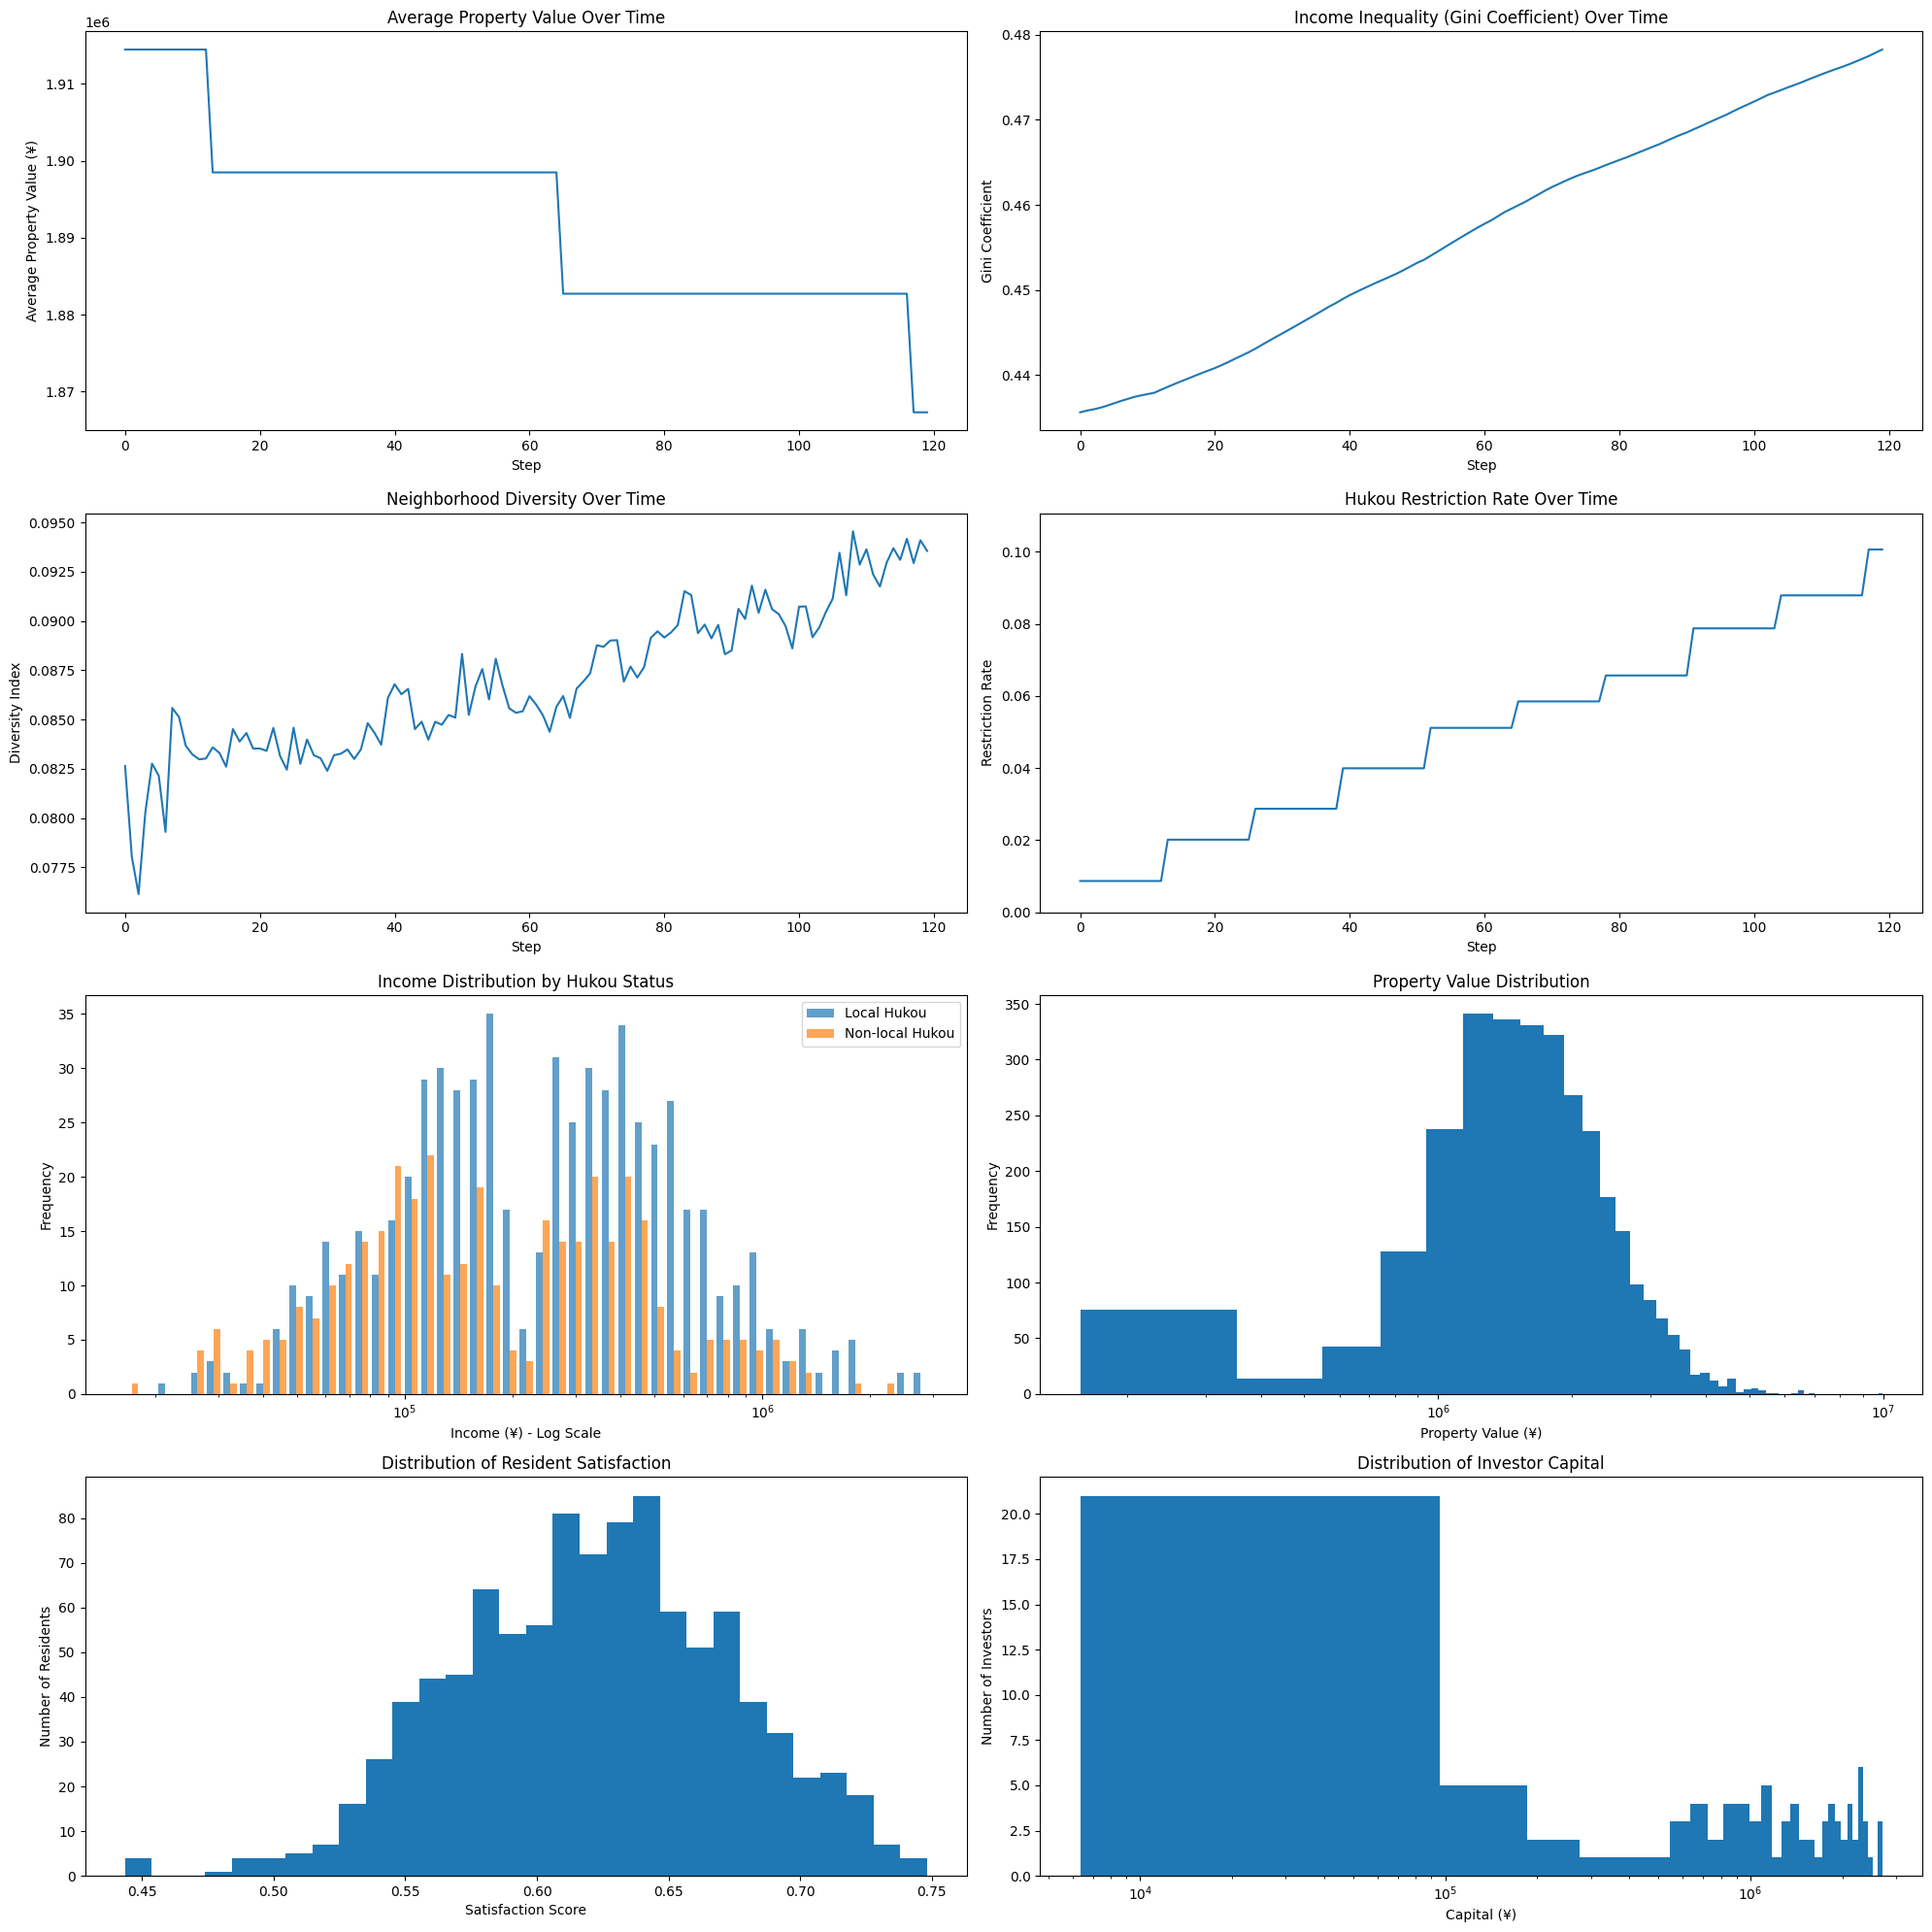

Total number of businesses: 15
Number of businesses with valid locations: 15
Unique business locations: 15
Number of properties with valid data: 3090


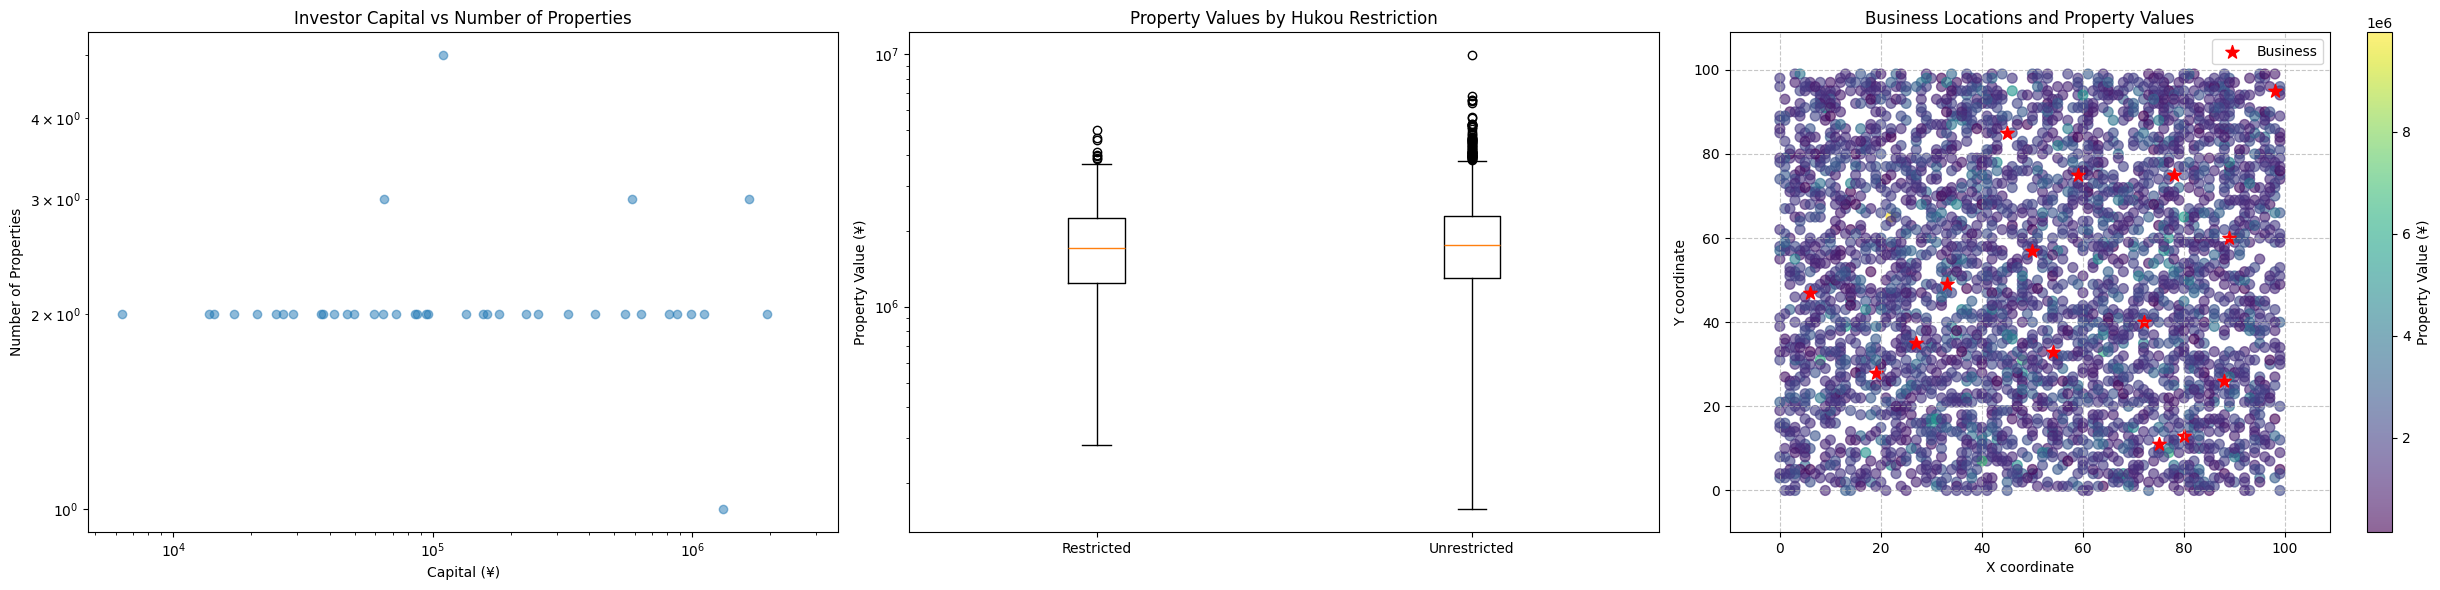

Key Statistics:
Average Resident Income: ¥324101.46
Average Property Value: ¥1867312.09
Average Resident Satisfaction: 0.62
Average Investor Capital: ¥1109500.20
Number of Businesses: 15


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assume model_data and agent_data_final are already prepared

# Prepare data
resident_data = agent_data_final[agent_data_final['Type'] == 'Resident']
property_data = agent_data_final[agent_data_final['Type'] == 'Property']
investor_data = agent_data_final[agent_data_final['Type'] == 'Investor']
business_data = agent_data_final[agent_data_final['Type'] == 'Business']

# Create the figure
plt.figure(figsize=(20, 20))

# 1. Time Series Plots
plt.subplot(421)
plt.plot(model_data["Average Property Value"])
plt.title("Average Property Value Over Time")
plt.xlabel("Step")
plt.ylabel("Average Property Value (¥)")

plt.subplot(422)
plt.plot(model_data["Gini Coefficient"])
plt.title("Income Inequality (Gini Coefficient) Over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")

plt.subplot(423)
plt.plot(model_data["Neighborhood Diversity"])
plt.title("Neighborhood Diversity Over Time")
plt.xlabel("Step")
plt.ylabel("Diversity Index")

plt.subplot(424)
plt.plot(model_data["Hukou Restriction Rate"])
plt.title("Hukou Restriction Rate Over Time")
plt.xlabel("Step")
plt.ylabel("Restriction Rate")
plt.ylim(0, max(model_data["Hukou Restriction Rate"]) * 1.1)

# 2. Distribution Plots
plt.subplot(425)
local_income = resident_data[resident_data['Hukou Status'] == 'Local']['Income']
non_local_income = resident_data[resident_data['Hukou Status'] == 'Non-local']['Income']
bins = np.logspace(np.log10(min(local_income.min(), non_local_income.min())),
                   np.log10(max(local_income.max(), non_local_income.max())), 50)
plt.hist([local_income, non_local_income], bins=bins, label=['Local Hukou', 'Non-local Hukou'], alpha=0.7)
plt.xscale('log')
plt.title('Income Distribution by Hukou Status')
plt.xlabel('Income (¥) - Log Scale')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(426)
plt.hist(property_data['Property Value'].dropna(), bins=50)
plt.title('Property Value Distribution')
plt.xlabel('Property Value (¥)')
plt.ylabel('Frequency')
plt.xscale('log')

plt.subplot(427)
plt.hist(resident_data['Satisfaction'].dropna(), bins=30)
plt.title("Distribution of Resident Satisfaction")
plt.xlabel("Satisfaction Score")
plt.ylabel("Number of Residents")

plt.subplot(428)
plt.hist(investor_data['Capital'].dropna(), bins=30)
plt.title("Distribution of Investor Capital")
plt.xlabel("Capital (¥)")
plt.ylabel("Number of Investors")
plt.xscale('log')

plt.tight_layout()
plt.show()

# 3. Additional Plots
plt.figure(figsize=(25, 6))  # Increase figure size for better readability

# Investor Capital vs Number of Properties
plt.subplot(131)
plt.scatter(investor_data['Capital'], investor_data['NumProperties'], alpha=0.5)
plt.title('Investor Capital vs Number of Properties')
plt.xlabel('Capital (¥)')
plt.ylabel('Number of Properties')
plt.xscale('log')
plt.yscale('log')  # Use log scale for better distribution visualization

# Property Values by Hukou Restriction
plt.subplot(132)
restricted = property_data[property_data['Hukou Restricted'] == True]['Property Value'].dropna()
unrestricted = property_data[property_data['Hukou Restricted'] == False]['Property Value'].dropna()
plt.boxplot([restricted, unrestricted], tick_labels=['Restricted', 'Unrestricted'])
plt.title("Property Values by Hukou Restriction")
plt.ylabel("Property Value (¥)")
plt.yscale('log')  # Use log scale for better distribution visualization

# Business Locations and Surrounding Property Values
plt.subplot(133)
valid_business_data = business_data.dropna(subset=['X', 'Y'])
valid_property_data = property_data.dropna(subset=['X', 'Y', 'Property Value'])

if not valid_business_data.empty and not valid_property_data.empty:
    plt.scatter(valid_property_data['X'], valid_property_data['Y'], 
                c=valid_property_data['Property Value'], cmap='viridis', 
                alpha=0.6, s=50)
    plt.colorbar(label='Property Value (¥)')
    
    plt.scatter(valid_business_data['X'], valid_business_data['Y'], 
                color='red', s=100, marker='*', label='Business')
    
    plt.title("Business Locations and Property Values")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    
    x_all = np.concatenate([valid_business_data['X'], valid_property_data['X']])
    y_all = np.concatenate([valid_business_data['Y'], valid_property_data['Y']])
    
    x_min, x_max = x_all.min(), x_all.max()
    y_min, y_max = y_all.min(), y_all.max()
    
    x_margin = max((x_max - x_min) * 0.1, 0.1)
    y_margin = max((y_max - y_min) * 0.1, 0.1)
    
    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
else:
    plt.text(0.5, 0.5, "No valid data", ha='center', va='center')
    plt.title("Business Locations and Property Values (No Data)")

# Add some additional diagnostic information
print("Total number of businesses:", len(business_data))
print("Number of businesses with valid locations:", len(valid_business_data))
print("Unique business locations:", valid_business_data[['X', 'Y']].drop_duplicates().shape[0])
print("Number of properties with valid data:", len(valid_property_data))

plt.tight_layout()
plt.show()

# Print key statistics
print("Key Statistics:")
print(f"Average Resident Income: ¥{resident_data['Income'].mean():.2f}")
print(f"Average Property Value: ¥{property_data['Property Value'].mean():.2f}")
print(f"Average Resident Satisfaction: {resident_data['Satisfaction'].mean():.2f}")
print(f"Average Investor Capital: ¥{investor_data['Capital'].mean():.2f}")
print(f"Number of Businesses: {len(business_data)}")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_parameter_study(param_ranges, steps=20):  # Added steps parameter, default is 20
    results = []
    for num_residents in param_ranges["num_residents"]:
        for num_investors in param_ranges["num_investors"]:
            for hukou_ratio in param_ranges["hukou_ratio"]:
                try:
                    # Calculate grid size
                    total_agents = num_residents + num_investors
                    grid_size = max(20, int((total_agents / 0.7) ** 0.5))
                    
                    print(f"Running simulation: {num_residents} residents, {num_investors} investors, hukou ratio {hukou_ratio}")
                    model = HousingMarketModel(num_residents, num_investors, grid_size, grid_size)
                    
                    # Run the simulation for the specified number of steps
                    for _ in range(steps):
                        model.step()
                    
                    # Collect data
                    final_data = model.datacollector.get_model_vars_dataframe().iloc[-1]
                    agent_data = model.datacollector.get_agent_vars_dataframe()
                    
                    resident_data = agent_data[agent_data['Type'] == 'Resident']
                    
                    # Append results
                    results.append({
                        "num_residents": num_residents,
                        "num_investors": num_investors,
                        "hukou_ratio": hukou_ratio,
                        "avg_property_value": final_data["Average Property Value"],
                        "gini_coefficient": final_data["Gini Coefficient"],
                        "neighborhood_diversity": final_data["Neighborhood Diversity"],
                        "hukou_restriction_rate": final_data["Hukou Restriction Rate"],
                        "avg_resident_satisfaction": resident_data['Satisfaction'].mean()
                    })
                    
                    print("Simulation completed successfully")
                except Exception as e:
                    print(f"Error in simulation: {str(e)}")
    
    return pd.DataFrame(results)

param_ranges = {
    "num_residents": [500, 1000, 1500, 2000],
    "num_investors": [25, 50, 75, 100],
    "hukou_ratio": [0.5, 0.6, 0.7, 0.8, 0.9]  # Ratio of local hukou population
}

# Run parameter study with specified steps
study_results = run_parameter_study(param_ranges, steps=20)

# Print summary of results
print(study_results.describe())

# Analyze the impact of parameters on results
for param in ["num_residents", "num_investors", "hukou_ratio"]:
    for metric in ["avg_property_value", "gini_coefficient", "neighborhood_diversity", "hukou_restriction_rate"]:
        correlation = study_results[param].corr(study_results[metric])
        print(f"Correlation between {param} and {metric}: {correlation:.4f}")

# Find the best parameter combination (e.g., lowest Gini coefficient)
best_params = study_results.loc[study_results['gini_coefficient'].idxmin()]
print("\nBest parameters for lowest Gini coefficient:")
print(best_params)

# Visualize results
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.scatter(study_results['num_residents'], study_results['avg_property_value'])
plt.xlabel('Number of Residents')
plt.ylabel('Average Property Value (¥)')
plt.title('Impact of Number of Residents on Property Value')

plt.subplot(222)
plt.scatter(study_results['num_investors'], study_results['gini_coefficient'])
plt.xlabel('Number of Investors')
plt.ylabel('Gini Coefficient')
plt.title('Impact of Number of Investors on Income Inequality')

plt.subplot(223)
plt.scatter(study_results['hukou_ratio'], study_results['neighborhood_diversity'])
plt.xlabel('Local Hukou Ratio')
plt.ylabel('Neighborhood Diversity')
plt.title('Impact of Hukou Ratio on Neighborhood Diversity')

plt.subplot(224)
plt.scatter(study_results['hukou_ratio'], study_results['hukou_restriction_rate'])
plt.xlabel('Local Hukou Ratio')
plt.ylabel('Hukou Restriction Rate')
plt.title('Impact of Hukou Ratio on Restriction Rate')

plt.tight_layout()
plt.show()

Running simulation: 500 residents, 25 investors, hukou ratio 0.5
Simulation completed successfully
Running simulation: 500 residents, 25 investors, hukou ratio 0.6
Simulation completed successfully
Running simulation: 500 residents, 25 investors, hukou ratio 0.7
Simulation completed successfully
Running simulation: 500 residents, 25 investors, hukou ratio 0.8
Simulation completed successfully
Running simulation: 500 residents, 25 investors, hukou ratio 0.9
Simulation completed successfully
Running simulation: 500 residents, 50 investors, hukou ratio 0.5
Simulation completed successfully
Running simulation: 500 residents, 50 investors, hukou ratio 0.6
Simulation completed successfully
Running simulation: 500 residents, 50 investors, hukou ratio 0.7
Simulation completed successfully
Running simulation: 500 residents, 50 investors, hukou ratio 0.8
Simulation completed successfully
Running simulation: 500 residents, 50 investors, hukou ratio 0.9
Simulation completed successfully
Running si

KeyboardInterrupt: 

NameError: name 'study_results' is not defined

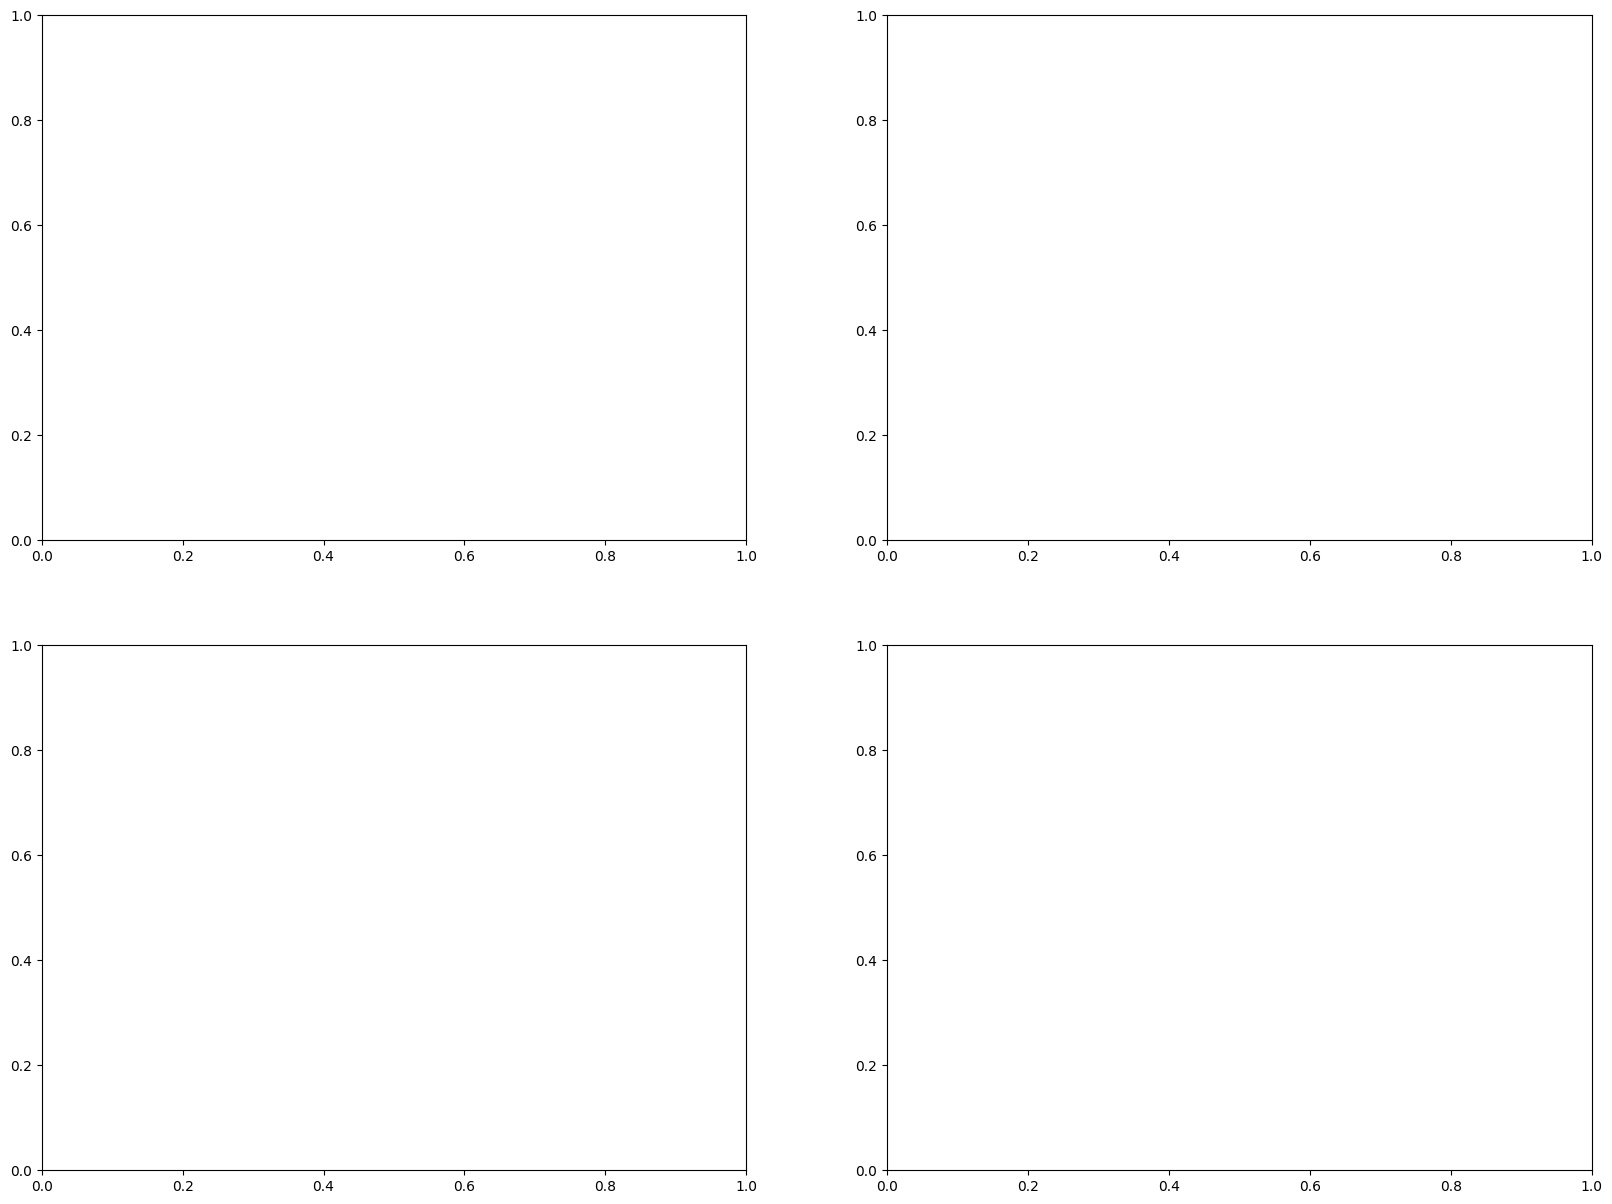

In [5]:
import matplotlib.pyplot as plt

# Visualize parameter study results
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
metrics = ["avg_property_value", "gini_coefficient", "neighborhood_diversity", "hukou_restriction_rate"]
titles = ["Average Property Value", "Gini Coefficient", "Neighborhood Diversity", "Hukou Restriction Rate"]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row = i // 2
    col = i % 2
    for num_residents in param_ranges["num_residents"]:
        for hukou_ratio in param_ranges["hukou_ratio"]:
            data = study_results[(study_results["num_residents"] == num_residents) &
                                 (study_results["hukou_ratio"] == hukou_ratio)].groupby("num_investors")[metric].mean()
            axs[row, col].plot(data.index, data.values,
                               label=f"{num_residents} residents, {hukou_ratio:.1f} local hukou ratio")
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel("Number of Investors")
    axs[row, col].set_ylabel(title)
    axs[row, col].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

# Visualize the impact of hukou ratio
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row = i // 2
    col = i % 2
    for num_residents in param_ranges["num_residents"]:
        for num_investors in param_ranges["num_investors"]:
            data = study_results[(study_results["num_residents"] == num_residents) &
                                 (study_results["num_investors"] == num_investors)].groupby("hukou_ratio")[metric].mean()
            axs[row, col].plot(data.index, data.values,
                               label=f"{num_residents} residents, {num_investors} investors")
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel("Local Hukou Ratio")
    axs[row, col].set_ylabel(title)
    axs[row, col].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

# Check if 'avg_resident_satisfaction' exists, if not, use 'avg_resident_satisfaction'
income_column = 'avg_resident_satisfaction' if 'avg_resident_satisfaction' in study_results.columns else 'avg_resident_satisfaction'

plt.figure(figsize=(10, 8))
for num_residents in param_ranges["num_residents"]:
    for num_investors in param_ranges["num_investors"]:
        data = study_results[(study_results["num_residents"] == num_residents) &
                             (study_results["num_investors"] == num_investors)]
        plt.scatter(data[income_column], data[income_column],
                    label=f"{num_residents} residents, {num_investors} investors")

plt.xlabel(f"Average Resident Satisfaction")
plt.ylabel(f"Average Resident Satisfaction")
plt.title("Resident Satisfaction for Different Model Configurations")
plt.legend(fontsize='x-small')
max_value = study_results[income_column].max()
plt.plot([0, max_value], [0, max_value], 'r--', label='Equal Line')
plt.legend()
plt.show()